# Machine Learning and Statistics for Physicists

## Homework 3

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
from sklearn import neighbors, cluster

In [3]:
from mls import locate_data
blobs_data = pd.read_hdf(locate_data('blobs_data.hf5'))

### Problem 1

Review [this notebook](https://nbviewer.jupyter.org/github/dkirkby/MachineLearningStatistics/blob/master/notebooks/Nonlinear.ipynb) on adapting linear methods to non-linear problems.  The key insight here that will be useful later in the course is the **kernel trick**, which is responsible for most of the expressive power of neural networks.

There is nothing graded to submit for this problem.

### Problem 2

Pick a dataset to "adopt" for this quarter.  Your dataset should:
 - be in the public domain (even if it is not already publicly available), and
 - be in the standard 2D tabular format used for ML algorithms, with columns corresponding to features and rows to observations (samples), and
 - have a number of features (D) and samples (N) that satisfies D * N < 1,000,000 (so trim a larger dataset, if necessary).
 
I encourage you to use some (real or simulated) data related to your research, but any dataset is ok.

Fill in the function below to load your dataset into a pandas dataframe. Your code can either read a file (I recommend CSV or HDF5 format) from your homework repo, if it is small enough (< 2 Mb) or else download the file from a public URL (some of the [pandas readers](https://pandas.pydata.org/pandas-docs/stable/api.html#input-output) can read directly from a URL). Include any steps necessary to get your final dataframe into the required format.

In [4]:
def load_adopted_data():
    # YOUR CODE HERE
    httsig = pd.read_table("http://mlphysics.ics.uci.edu/data/htautau/htautau.txt.gz",header=None,nrows=19999)
    httbkg = pd.read_table("http://mlphysics.ics.uci.edu/data/htautau/ztautau.txt.gz",header=None,nrows=19999)
    httsig.columns = ['hl1','hl2','hl3','hl4','hl5','hl6','hl7','hl8','hl9','hl10','hh1','hh2','hh3','hh4','hh5','hh6','hh7','hh8','hh9','hh10','hh11','hh12','hh13','hh14','hh15']
    httbkg.columns = ['zl1','zl2','zl3','zl4','zl5','zl6','zl7','zl8','zl9','zl10','zh1','zh2','zh3','zh4','zh5','zh6','zh7','zh8','zh9','zh10','zh11','zh12','zh13','zh14','zh15']
    combdat = pd.concat([httsig,httbkg],axis=1,sort=False)
    print (combdat.shape)
    return combdat
    raise NotImplementedError()

In [5]:
# A correct solution should pass these tests.
df = load_adopted_data()
N, D = df.shape
assert N * D < 1000000

(19999, 50)


Generate a high-level summary of the (first 10) numeric features of your data using:

In [6]:
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
df[numeric_features[:10]].describe()

,hl1,hl2,hl3,hl4,hl5,hl6,hl7,hl8,hl9,hl10
count,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000
mean,35.565467,0.007939,-0.007700,29.744635,0.011725,0.001251,43.167252,-0.002258,28.725570,-0.000845
std,11.016996,1.129374,1.815157,8.939718,1.143941,1.805383,23.598261,1.826017,22.308783,1.658892
min,20.002000,-2.499250,-3.141200,20.001700,-2.494720,-3.140920,0.301833,-31.000000,0.000000,-3.140550
25%,27.094600,-0.847460,-1.583785,23.125500,-0.858957,-1.572945,25.514550,-1.535165,11.388200,-1.299660
50%,33.671100,0.008774,-0.000538,27.289900,0.008574,0.020857,40.160500,-0.035915,26.927900,0.000000
75%,41.814300,0.858061,1.564620,33.793850,0.874547,1.560975,57.494100,1.562246,40.518050,1.306810
max,118.701000,2.498490,3.141470,126.789000,2.499700,3.141320,213.222000,21.000000,182.668000,3.141420


Perform a high-level visualization of your data using (feel free to edit `vars` to select the most informative features):

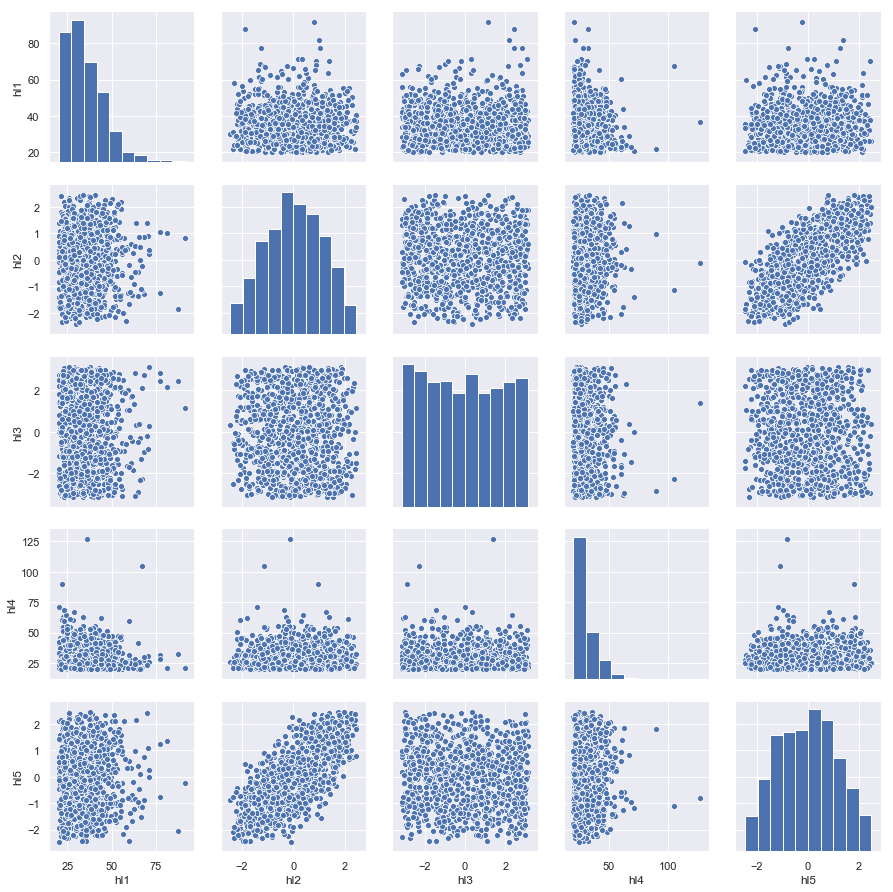

In [7]:
# Only plot up to 5 numeric features of up to 1000 rows with valid data.
valid = df.dropna()
numeric_features = valid.select_dtypes(include=[np.number]).columns.tolist()
sns.pairplot(valid.iloc[:1000], vars=numeric_features[:5]);

Find the best assignment to 3 clusters using Kmeans (or change the value of `n_clusters` below to something more appropriate):

In [8]:
valid = df.dropna().copy()
numeric_features = valid.select_dtypes(include=[np.number]).columns.tolist()
fit = cluster.KMeans(n_clusters=3).fit(valid[numeric_features])
valid['cluster'] = fit.labels_
for i in range(fit.n_clusters):
    print(f'Assigned {np.count_nonzero(fit.labels_ == i)} / {len(valid)} samples to cluster {i}.')

Assigned 13698 / 19999 samples to cluster 0.
Assigned 3055 / 19999 samples to cluster 1.
Assigned 3246 / 19999 samples to cluster 2.


Redo the pairplot with samples colored by their cluster assignment:

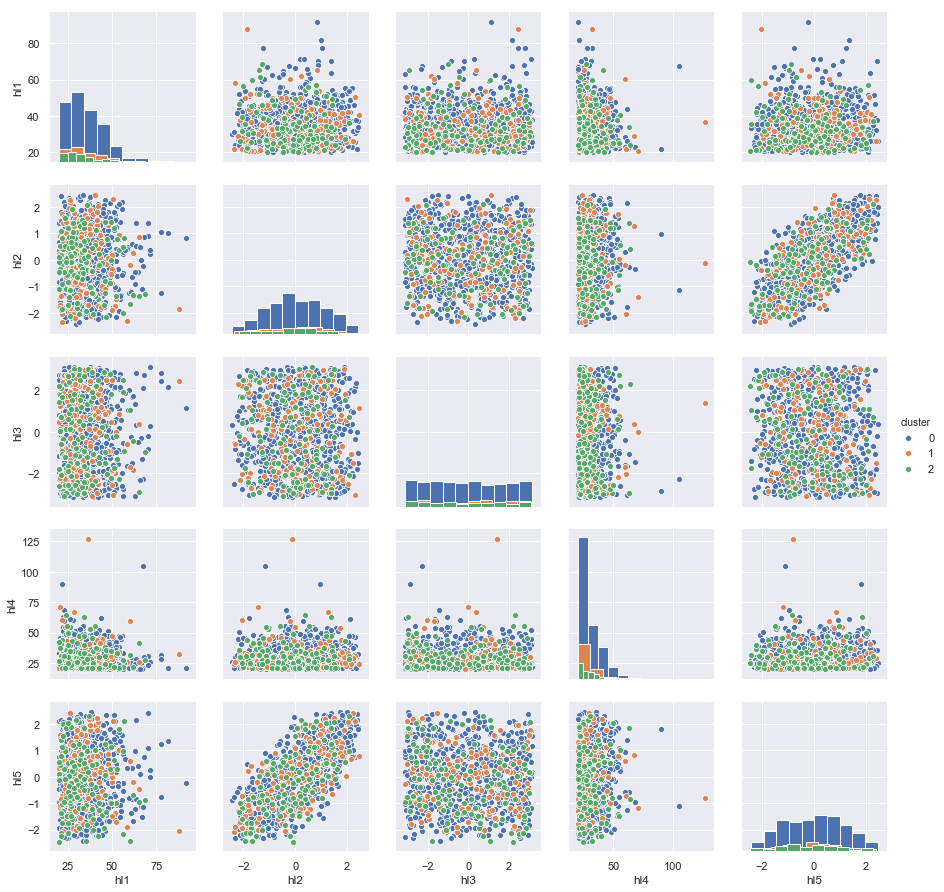

In [9]:
sns.pairplot(valid.iloc[:1000], vars=numeric_features[:5], hue='cluster', diag_kind='hist');

### Problem 3

In this problem you will implement the core of the E- and M-steps for the [Gaussian mixture model (GMM)](http://scikit-learn.org/stable/modules/mixture.html) method. Note the similarities with the E- and M-steps of the K-means method.

First, implement the function below to evaluate the [multidimensional Gaussian probability density](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) for arbitrary mean $\vec{\mu}$ and covariance matrix $C$ (refer to the lecture for more details on the notation used here):
$$
G(\vec{x} ; \vec{\mu}, C) = \left(2\pi\right)^{-D/2}\,\left| C\right|^{-1/2}\,
\exp\left[  -\frac{1}{2} \left(\vec{x} - \vec{\mu}\right)^T C^{-1} \left(\vec{x} - \vec{\mu}\right) \right]
$$

In [10]:
def Gaussian_pdf(x, mu, C):
    """Evaluate the Gaussian probability density.
    
    Parameters
    ----------
    x : array
        1D array of D feature values for a single sample
    mu : array
        1D array of D mean feature values for this component.
    C : array
        2D array with shape (D, D) of covariance matrix elements for this component.
        Must be positive definite (and therefore symmetric).
        
    Returns
    -------
    float
        Probability density.
    """
    x = np.asarray(x)
    mu = np.asarray(mu)
    C = np.asarray(C)
    D = len(x)
    assert x.shape == (D,) and mu.shape == (D,)
    assert C.shape == (D, D)
    assert np.allclose(C.T, C)
    xm = x-mu
    xmt = xm.transpose()
    cdet = np.linalg.det(C)
    return (1/np.sqrt(cdet))*np.exp(np.sum(np.dot(np.linalg.inv(C),xm)*xm*(-.5)))*((1/np.sqrt(2*np.pi))**D)
    
    
    # YOUR CODE HERE
    raise NotImplementedError()

In [11]:
# A correct solution should pass these tests.
assert np.allclose(Gaussian_pdf([0], [0], [[1]]), 1 / np.sqrt(2 * np.pi))
assert np.allclose(Gaussian_pdf([1], [1], [[1]]), 1 / np.sqrt(2 * np.pi))
assert np.allclose(Gaussian_pdf([0], [0], [[2]]), 1 / np.sqrt(4 * np.pi))
assert np.allclose(Gaussian_pdf([1], [0], [[1]]), np.exp(-0.5) / np.sqrt(2 * np.pi))

assert np.allclose(Gaussian_pdf([0, 0], [0, 0], [[1, 0], [0, 1]]), 1 / (2 * np.pi))
assert np.allclose(Gaussian_pdf([1, 0], [1, 0], [[1, 0], [0, 1]]), 1 / (2 * np.pi))
assert np.allclose(Gaussian_pdf([1, -1], [1, -1], [[1, 0], [0, 1]]), 1 / (2 * np.pi))
assert np.allclose(Gaussian_pdf([1, 0], [1, 0], [[4, 0], [0, 1]]), 1 / (4 * np.pi))

assert np.round(Gaussian_pdf([0, 0], [1, 0], [[4, +1], [+1, 1]]), 5) == 0.07778
assert np.round(Gaussian_pdf([0, 0], [1, 0], [[4, -1], [-1, 1]]), 5) == 0.07778
assert np.round(np.log(Gaussian_pdf([1, 0, -1], [1, 2, 3], [[4, -1, 0], [-1, 1, 0], [0, 0, 2]])), 5) == -10.31936

Next, implement the E-step in the function below. This consists of calculating the relative probability that each sample $\vec{x}_n$ ($n$-th row of $X$) belongs to each component $k$:
$$
p_{nk} = \frac{\omega_k G(\vec{x}_n; \vec{\mu}_k, C_k)}
{\sum_{j=1}^K\, \omega_j G(\vec{x}_n; \vec{\mu}_j, C_j)}
$$
Note that these relative probabilities (also called *responsibilities*) sum to one over components $k$ for each sample $n$.  Also note that we consider the parameters ($\omega_k$, $\vec{\mu}_k$, $C_k$) of each component fixed during this step. *Hint: use your `Gaussian_pdf` function here.*

In [12]:
def E_step(X, w, mu, C):
    """Perform a GMM E-step.
    
    Parameters
    ----------
    X : array with shape (N, D)
        Input data consisting of N samples in D dimensions.
    w : array with shape (K,)
        Per-component weights.
    mu : array with shape (K, D)
        Array of mean vectors for each component.
    C : array with shape (K, D, D).
        Array of covariance matrices for each component.
    
    Returns
    -------
    array with shape (K, N)
        Array of relative probabilities that each sample belongs to
        each component, normalized so that the per-component probabilities
        for each sample sum to one.
    """
    N, D = X.shape
    K = len(w)
    assert w.shape == (K,)
    assert mu.shape == (K, D)
    assert C.shape == (K, D, D)
    # YOUR CODE HERE
    ilist = list(range(K))
    nlist = list(range(N))
    outt = []
    for i in range(N):
        outl = list(map(lambda x: w[x]*Gaussian_pdf(X[i],mu[x],C[x]),ilist))
        suml = np.sum(outl)
        outt.append(outl/suml)
    #sumn = np.sum(outl)
    #outt = np.array(outl/sumn)
    
    #allout = 
    #print (np.transpose(outt))
    return np.transpose(outt)
    raise NotImplementedError()




In [13]:
# A correct solution should pass these tests.
X = np.linspace(-1, 1, 5).reshape(-1, 1)
w = np.full(4, 0.25)
mu = np.array([[-2], [-1], [0], [1]])
C = np.ones((4, 1, 1))
#print(repr(np.round(E_step(X, w, mu, C), 3)))
assert np.all(
    np.round(E_step(X, w, mu, C), 3) ==
    [[ 0.258,  0.134,  0.058,  0.021,  0.006],
     [ 0.426,  0.366,  0.258,  0.152,  0.077],
     [ 0.258,  0.366,  0.426,  0.414,  0.346],
     [ 0.058,  0.134,  0.258,  0.414,  0.57 ]])

X = np.zeros((1, 3))
w = np.ones((2,))
mu = np.zeros((2, 3))
C = np.zeros((2, 3, 3))
diag = range(3)
C[:, diag, diag] = 1
#print(repr(np.round(E_step(X, w, mu, C), 3)))
assert np.all(
    np.round(E_step(X, w, mu, C), 3) ==
    [[ 0.5], [ 0.5]])

X = np.array([[0,0,0], [1,0,0]])
mu = np.array([[0,0,0], [1,0,0]])
#print(repr(np.round(E_step(X, w, mu, C), 3)))
assert np.all(
    np.round(E_step(X, w, mu, C), 3) ==
    [[ 0.622,  0.378], [ 0.378,  0.622]])

gen = np.random.RandomState(seed=123)
K, N, D = 4, 1000, 5
X = gen.normal(size=(N, D))
subsample = X.reshape(K, (N//K), D)
mu = subsample.mean(axis=1)
C = np.empty((K, D, D))
w = gen.uniform(size=K)
w /= w.sum()
for k in range(K):
    C[k] = np.cov(subsample[k], rowvar=False)
#print(repr(np.round(E_step(X, w, mu, C)[:, :5], 3)))
assert np.all(
    np.round(E_step(X, w, mu, C)[:, :5], 3) ==
    [[ 0.422,  0.587,  0.344,  0.279,  0.19 ],
     [ 0.234,  0.11 ,  0.269,  0.187,  0.415],
     [ 0.291,  0.194,  0.309,  0.414,  0.279],
     [ 0.053,  0.109,  0.077,  0.12 ,  0.116]])

Finally, implement the M-step in the function below.  During this step, we consider the relative weights $p_{nk}$ from the previous step fixed and instead update the parameters of each component (which were fixed in the previous step), using:
$$
\begin{aligned}
\omega_k &= \frac{1}{N}\, \sum_{n=1}^N\, p_{nk} \\
\vec{\mu}_k &= \frac{\sum_{n=1}^N\, p_{nk} \vec{x}_n}{\sum_{n=1}^N\, p_{nk}} \\
C_k &= \frac{\sum_{n=1}^N\, p_{nk} \left( \vec{x}_n - \vec{\mu}_k\right) \left( \vec{x}_n - \vec{\mu}_k\right)^T}
{\sum_{n=1}^N\, p_{nk}}
\end{aligned}
$$
Make sure you understand why the last expression yields a matrix rather than a scalar dot product before jumping into the code. (If you would like a numpy challenge, try implementing this function without any loops, e.g., with `np.einsum`)

In [14]:
def M_step(X, p):
    """Perform a GMM M-step.
    
    Parameters
    ----------
    X : array with shape (N, D)
        Input data consisting of N samples in D dimensions.
    p : array with shape (K, N)
        Array of relative probabilities that each sample belongs to
        each component, normalized so that the per-component probabilities
        for each sample sum to one.
    
    Returns
    -------
    tuple
        Tuple w, mu, C of arrays with shapes (K,), (K, D) and (K, D, D) giving
        the updated component parameters.
    """
    N, D = X.shape
    K = len(p)
    assert p.shape == (K, N)
    assert np.allclose(p.sum(axis=0), 1)
    # YOUR CODE HERE
    #w = list(map(lambda x: np.sum(p[x])/N,list(range(K))))
    #map(lambda x: np.dot(p,X[x]),list(range[N]))
    w = np.sum(p,axis=1)/N
    #we = map(lambda i: p[i])
    mui = np.einsum("ij,jk->ik",p,X)
    #mu = list(map(lambda x: w[x]*mui[x]*N,list(range(K))))
    mu = np.zeros((K,D))
    cout = np.zeros((K,D,D))
    
    for i in range(K):
        for j in range(N):
            mu[i]+=p[i,j]*X[j]/(N*w[i])
    
    for i in range(K):
        for j in range(N):
            
            xu = X[j]-mu[i]
            #xx = np.einsum("i,j->ij",xu,xu)
            xx = np.outer(xu,xu)
            xx*=(p[i,j]/(N*w[i]))
            cout[i]+=xx
    #print (cout)
    """
    xk = np.full((K,N,D),X)
    mn = np.full((N,K,D),mu)
    mnn = mn.transpose(0,1)
    xm = xk - mnn
    xmd = np.full((D,K,N,D),xm).transpose(0,2)
    xx = xmd.transpose(2,3)*xmd
    XS = xx.transpose(0,1)
    xuu = list(map(lambda x: np.array(np.einsum("j,jkl->kl",p[x],XS[x])),list(range(K))))
    #xu = np.einsum("kn,kni,knj->kij",p,(xk-mnn),(xk-mnn))
    """
    return w,mu,cout
    
    raise NotImplementedError()
#print([[1,2,3]]*[[4],[5],[6]])

In [15]:
# A correct solution should pass these tests.
X = np.linspace(-1, 1, 5).reshape(-1, 1)
p = np.full(20, 0.25).reshape(4, 5)
w, mu, C = M_step(X, p)
#print(repr(np.round(w, 5)))
#print(repr(np.round(mu, 5)))
#print(repr(np.round(C, 5)))
assert np.all(np.round(w, 5) == 0.25)
assert np.all(np.round(mu, 5) == 0.0)
assert np.all(np.round(C, 5) == 0.5)

gen = np.random.RandomState(seed=123)
K, N, D = 4, 1000, 5
X = gen.normal(size=(N, D))
p = gen.uniform(size=(K, N))
p /= p.sum(axis=0)
w, mu, C = M_step(X, p)
#print(repr(np.round(w, 5)))
#print(repr(np.round(mu, 5)))
#print(repr(np.round(C[0], 5)))
assert np.all(
    np.round(w, 5) == [ 0.25216,  0.24961,  0.24595,  0.25229])
assert np.all(
    np.round(mu, 5) ==
    [[ 0.06606,  0.06   , -0.00413,  0.01562,  0.00258],
     [ 0.02838,  0.01299,  0.01286,  0.03068, -0.01714],
     [ 0.03157,  0.04558, -0.01206,  0.03493, -0.0326 ],
     [ 0.05467,  0.06293, -0.01779,  0.04454,  0.00065]])
assert np.all(
    np.round(C[0], 5) ==
    [[ 0.98578,  0.01419, -0.03717,  0.01403,  0.0085 ],
     [ 0.01419,  0.95534, -0.02724,  0.03201, -0.00648],
     [-0.03717, -0.02724,  0.90722,  0.00313,  0.0299 ],
     [ 0.01403,  0.03201,  0.00313,  1.02891,  0.0813 ],
     [ 0.0085 , -0.00648,  0.0299 ,  0.0813 ,  0.922  ]])

You have now implemented the core of the GMM algorithm.  Here is a simple wrapper that uses KMeans to initialize the relative probabilities to all be either zero or one, based on each sample's cluster assignment:

In [16]:
from mls import GMM_pairplot

def GMM_fit(data, n_components, nsteps, init='random', seed=123):
    X = data.values
    N, D = X.shape
    gen = np.random.RandomState(seed=seed)
    p = np.zeros((n_components, N))
    if init == 'kmeans':
        # Use KMeans to divide the data into clusters.
        fit = cluster.KMeans(n_clusters=n_components, random_state=gen).fit(data)
        # Initialize the relative weights using cluster membership.
        # The initial weights are therefore all either 0 or 1.
        for k in range(n_components):
            p[k, fit.labels_ == k] = 1
    else:
        # Assign initial relative weights in quantiles of the first feature.
        # This is not a good initialization strategy, but shows how well
        # GMM converges from a poor starting point.
        x0 = X[:, 0]
        edges = np.percentile(x0, np.linspace(0, 100, n_components + 1))
        for k in range(n_components):
            quantile = (edges[k] <= x0) & (x0 <= edges[k + 1])
            p[k, quantile] = 1.
    # Normalize relative weights.
    p /= p.sum(axis=0)
    # Perform an initial M step to initialize the component params.
    w, mu, C = M_step(X, p)
    # Loop over iterations.
    for i in range(nsteps):
        p = E_step(X, w, mu, C)
        w, mu, C = M_step(X, p)
    # Plot the results.
    GMM_pairplot(data, w, mu, C)

Try this out on the 3D `blobs_data` and notice that it converges close to the correct solution after 8 iterations:

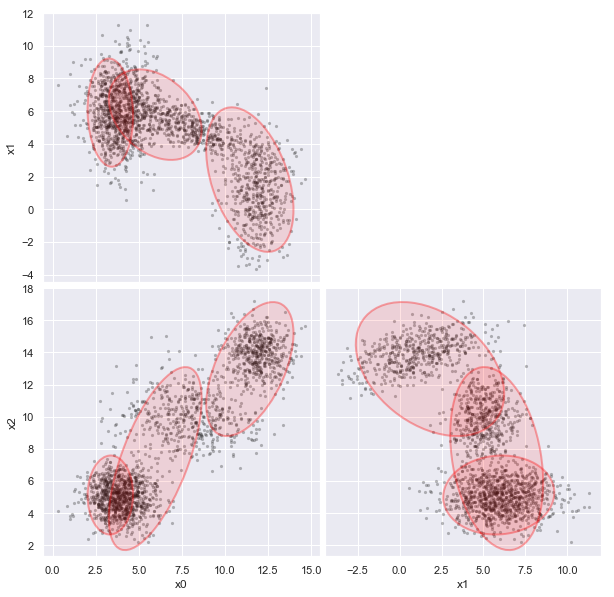

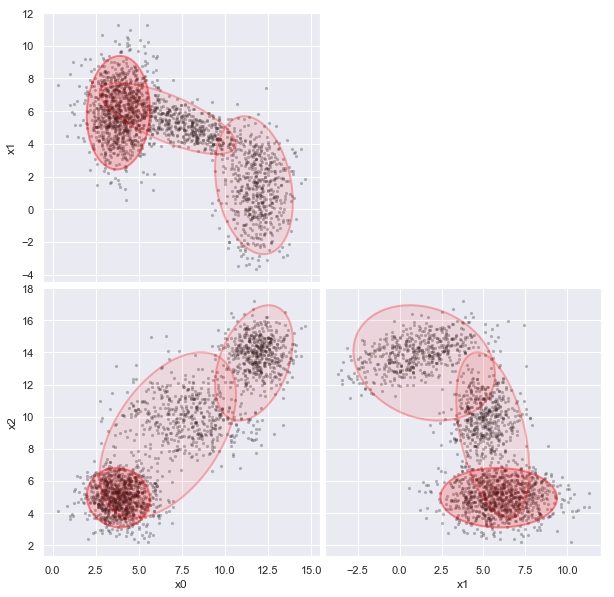

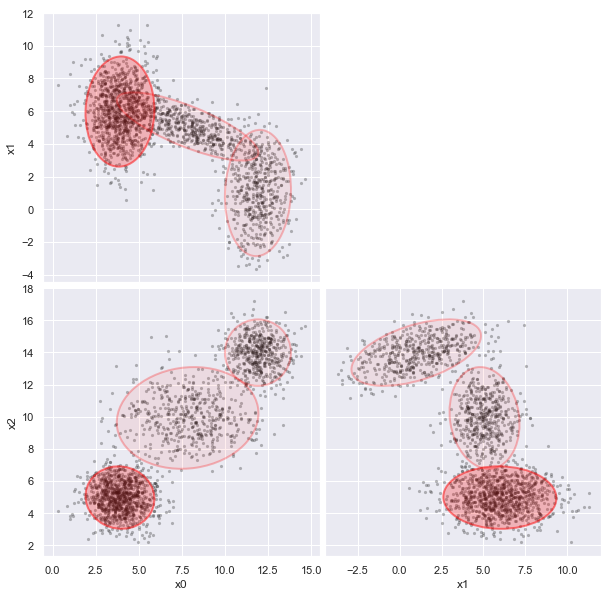

In [17]:
GMM_fit(blobs_data, 3, nsteps=0)
GMM_fit(blobs_data, 3, nsteps=4)
GMM_fit(blobs_data, 3, nsteps=8)

Convergence is even faster if you use KMeans to initialize the relative weights (which is why most implementations do this):

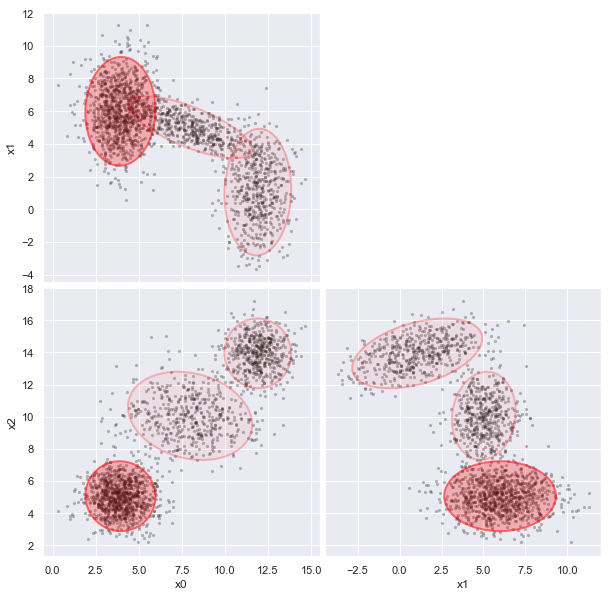

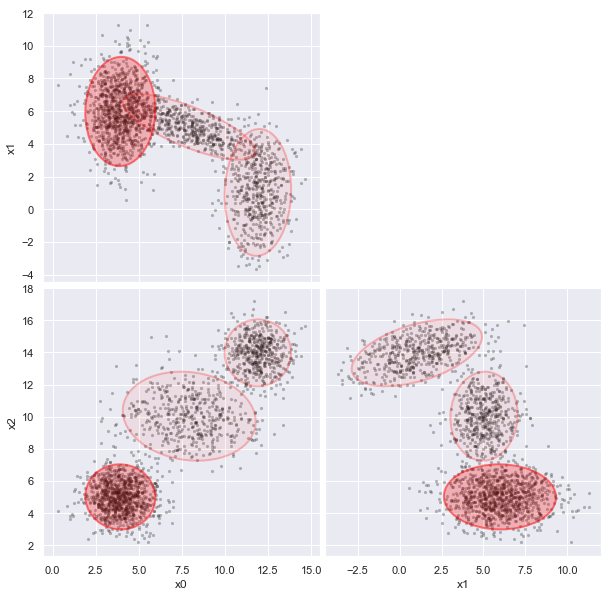

In [18]:
GMM_fit(blobs_data, 3, nsteps=0, init='kmeans')
GMM_fit(blobs_data, 3, nsteps=1, init='kmeans')

### Problem 4

A density estimator should provide a probability density function $P(\vec{x})$ that is normalized over its feature space $\vec{x}$
$$
\int d\vec{x}\, P(\vec{x}) = 1 \; .
$$
In this problem you will verify this normalization for KDE using two different numerical approaches for the integral.

First, implement the function below to accept a 1D KDE fit object and estimate its normalization integral using the trapezoid rule with the specified grid. *Hint: the `np.trapz` function will be useful.*

In [19]:
def check_grid_normalization(fit, xlo, xhi, ngrid):
    """Check 1D denstity estimator fit result normlization using grid quadrature.
    
    Parameters
    ----------
    fit : neighbors.kde.KernelDensity fit object
        Result of fit to 1D dataset.
    xlo : float
        Low edge of 1D integration range.
    xhi : float
        High edge of 1D integration range.
    ngrid : int
        Number of equally spaced grid points covering [xlo, xhi],
        including both end points.
    """
    # YOUR CODE HERE
    xg = np.linspace(xlo,xhi,ngrid)[:,np.newaxis]
    logp = fit.score_samples(xg)
    p = np.exp(logp)
    dx = xg[1]-xg[0]
    intp = np.trapz(p,dx=dx)
    return intp
    raise NotImplementedError()


In [20]:
# A correct solution should pass these tests.
fit = neighbors.kde.KernelDensity(kernel='gaussian', bandwidth=0.1).fit(blobs_data.drop(columns=['x1', 'x2']))
assert np.round(check_grid_normalization(fit, 0, 15, 5), 3) == 1.351
assert np.round(check_grid_normalization(fit, 0, 15, 10), 3) == 1.019
assert np.round(check_grid_normalization(fit, 0, 15, 20), 3) == 0.986
assert np.round(check_grid_normalization(fit, 0, 15, 100), 3) == 1.000

fit = neighbors.kde.KernelDensity(kernel='gaussian', bandwidth=0.1).fit(blobs_data.drop(columns=['x0', 'x2']))
assert np.round(check_grid_normalization(fit, -4, 12, 5), 3) == 1.108
assert np.round(check_grid_normalization(fit, -4, 12, 10), 3) == 0.993
assert np.round(check_grid_normalization(fit, -4, 12, 20), 3) == 0.971
assert np.round(check_grid_normalization(fit, -4, 12, 100), 3) == 1.000

fit = neighbors.kde.KernelDensity(kernel='gaussian', bandwidth=0.1).fit(blobs_data.drop(columns=['x0', 'x1']))
assert np.round(check_grid_normalization(fit, 2, 18, 5), 3) == 1.311
assert np.round(check_grid_normalization(fit, 2, 18, 10), 3) == 0.954
assert np.round(check_grid_normalization(fit, 2, 18, 20), 3) == 1.028
assert np.round(check_grid_normalization(fit, 2, 18, 100), 3) == 1.000

Next, implement the function below to estimate a multidimensional fit normalization using [Monte Carlo integration](https://en.wikipedia.org/wiki/Monte_Carlo_integration):
$$
\int d\vec{x}\, P(\vec{x}) \simeq \frac{V}{N_{mc}}\, \sum_{j=1}^{N_{mc}} P(\vec{x}_j) = V \langle P\rangle \; ,
$$
where the $\vec{x}_j$ are uniformly distributed over the integration domain and $V$ is the integration domain volume. Note that `trapz` gives more accurate results for a fixed number of $P(\vec{x})$ evaluations, but MC integration is much easier to generalize to higher dimensions.

In [21]:
def check_mc_normalization(fit, xlo, xhi, nmc, seed=123):
    """Check denstity estimator fit result normlization using MC integration.
    
    Parameters
    ----------
    fit : neighbors.kde.KernelDensity fit object
        Result of fit to arbitrary dataset of dimension D.
    xlo : array
        1D array of length D with low limits of integration domain along each dimension.
    xhi : array
        1D array of length D with high limits of integration domain along each dimension.
    nmc : int
        Number of random MC integration points within the domain to use.
    """
    xlo = np.asarray(xlo)
    xhi = np.asarray(xhi)
    
    V = np.prod(xhi-xlo)
    
    
    assert xlo.shape == xhi.shape
    assert np.all(xhi > xlo)
    D = len(xlo)
    gen = np.random.RandomState(seed=seed)
    # Use gen.uniform() in your solution, not gen.rand(), for consistent random numbers.
    # YOUR CODE HERE
    NN = np.ones(xlo.shape,dtype='int')*nmc
    xgen = gen.uniform(xlo,xhi,(nmc,len(xlo)))
    
    logden = fit.score_samples(xgen)
    xden = np.exp(logden)
    xs = np.sum(xden)/nmc
    return xs*V
    
    
    
    #raise NotImplementedError()

In [22]:
##### A correct solution should pass these tests.
fit = neighbors.kde.KernelDensity(kernel='gaussian', bandwidth=0.1).fit(blobs_data.drop(columns=['x1', 'x2']))
assert np.round(check_mc_normalization(fit, [0], [15], 10), 3) == 1.129
assert np.round(check_mc_normalization(fit, [0], [15], 100), 3) == 1.022
assert np.round(check_mc_normalization(fit, [0], [15], 1000), 3) == 1.010
assert np.round(check_mc_normalization(fit, [0], [15], 10000), 3) == 0.999

fit = neighbors.kde.KernelDensity(kernel='gaussian', bandwidth=0.1).fit(blobs_data.drop(columns=['x2']))
assert np.round(check_mc_normalization(fit, [0, -4], [15, 12], 10), 3) == 1.754
assert np.round(check_mc_normalization(fit, [0, -4], [15, 12], 100), 3) == 1.393
assert np.round(check_mc_normalization(fit, [0, -4], [15, 12], 1000), 3) == 0.924
assert np.round(check_mc_normalization(fit, [0, -4], [15, 12], 10000), 3) == 1.019

fit = neighbors.kde.KernelDensity(kernel='gaussian', bandwidth=0.1).fit(blobs_data)
assert np.round(check_mc_normalization(fit, [0, -4, 2], [15, 12, 18], 10), 3) == 2.797
assert np.round(check_mc_normalization(fit, [0, -4, 2], [15, 12, 18], 100), 3) == 0.613
assert np.round(check_mc_normalization(fit, [0, -4, 2], [15, 12, 18], 1000), 3) == 1.316
assert np.round(check_mc_normalization(fit, [0, -4, 2], [15, 12, 18], 10000), 3) == 1.139